In [1]:
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import timeit
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, transforms

from novelty.models.dists import benford_dist, instrumental_dist
from novelty.models.mlp import MLP
from novelty.models.util import train_streaming_unbalanced, test, train_streaming
from novelty.visualization.models import plot_accs

/Users/akshay/opt/anaconda3/envs/novelty/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_labels_and_class_counts(labels_list):
    '''
    Calculates the counts of all unique classes.
    '''
    labels = np.array(labels_list)
    _, class_counts = np.unique(labels, return_counts=True)
    return labels, class_counts

class ImbalancedMNIST(Dataset):
    def __init__(self, imbal_class_prop, root, train, download, transform):
        self.dataset = datasets.MNIST(root, train=train, download=download, transform=transform)
        self.train = train
        self.imbal_class_prop = imbal_class_prop
        self.idxs = self.resample()

    def get_labels_and_class_counts(self):
        return self.labels, self.imbal_class_counts

    def resample(self, nb_classes = 10):
        '''
        Resample the indices to create an artificially imbalanced dataset.
        '''
        targets, class_counts = get_labels_and_class_counts(self.dataset.targets)
            
        # Get class indices for resampling
        class_indices = [np.where(targets == i)[0] for i in range(nb_classes)]
        # Reduce class count by proportion
        self.imbal_class_counts = [int(count * prop) for count, prop in zip(class_counts, self.imbal_class_prop)]
        # Get class indices for reduced class count
        idxs = []
        for c in range(nb_classes):
            imbal_class_count = self.imbal_class_counts[c]
            idxs.append(class_indices[c][:imbal_class_count])
        idxs = np.hstack(idxs)
        self.labels = targets[idxs]
        return idxs

    def __getitem__(self, index):
        img, target = self.dataset[self.idxs[index]]
        return img, target

    def __len__(self):
        return len(self.idxs)

In [9]:
device = 'cpu'
train_kwargs = {'batch_size': 1, 
               'shuffle': True}
test_kwargs = {'batch_size': 1000,
              'shuffle':True}
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # image mean and std 
    ])

In [10]:
#benford_dist(torch.arange(10))*(1/max(benford_dist(torch.arange(10))))
imbal_class_prop = torch.tensor(5*[0.1] + 5*[1.0])
train_dataset_imbalanced = ImbalancedMNIST(
    imbal_class_prop, 
    root='../data/raw', 
    train=True, 
    download=False,
    transform = transform
)
test_dataset_imbalanced = ImbalancedMNIST(
    imbal_class_prop, 
    root='../data/raw', 
    train=False, 
    download=False,
    transform = transform
)

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset_imbalanced,**train_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset_imbalanced, **test_kwargs)

In [12]:
examples_per_epoch = 5000
batches_per_epoch = examples_per_epoch//train_kwargs['batch_size']
epochs = len(train_loader.dataset)//examples_per_epoch

In [13]:
model = MLP().to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.01)
kept_all = torch.zeros(10)
train_accs_normal = []
test_accs_normal = []

for epoch in tqdm(range(1, epochs + 1)):
    train_loss, train_acc, kept = train_streaming(model, device, train_loader, optimizer, epoch,
                                                 batches_per_epoch)
    test_loss, test_acc = test(model, device, test_loader)
    train_accs_normal.append(train_acc)
    test_accs_normal.append(test_acc)
    kept_all = kept_all + kept

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:32<00:00,  5.47s/it]


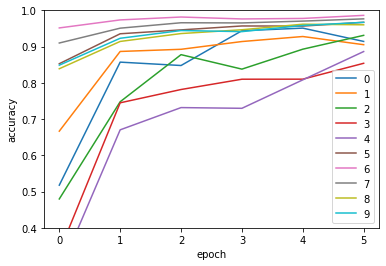

In [14]:
plot_accs(train_accs_normal)

# Weighted Resampling

In [ ]:
weights = 1. / torch.tensor(train_class_counts, dtype=torch.float)
samples_weights = weights[train_targets]
for name, count, weight in zip(class_names, train_class_counts, weights):
    print('Class {}: {} samples, {:.5} weight'.format(name, count, weight))

In [ ]:
from torch.utils.data.sampler import WeightedRandomSampler

sampler = WeightedRandomSampler(
    weights=samples_weights,
    num_samples=len(samples_weights),
    replacement=True)